In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
from poola import core as pool
import anchors

import core_functions as fns

gpp.set_aesthetics(palette='Set2')

In [13]:
def run_guide_residuals(lfc_df, paired_lfc_cols=[]):
    '''
    Calls get_guide_residuals function from anchors package to calculate guide-level residual z-scores
    Inputs:
    1. lfc_df: data frame with log-fold changes (relative to pDNA)
    2. paired_lfc_cols: grouped list of initial populations and corresponding resistant populations 
    
    '''
    lfc_df = lfc_df.drop_duplicates()
    if not paired_lfc_cols:
        paired_lfc_cols = fns.pair_cols(lfc_df)[1] #get lfc pairs 
    modified = []
    unperturbed = []
    #reference_df: column1 = modifier condition, column2 = unperturbed column
    ref_df = pd.DataFrame(columns=['modified', 'unperturbed'])
    row = 0 #row index for reference df 
    for pair in paired_lfc_cols:
        #number of resistant pops in pair = len(pair)-1
        res_idx = 1 
        #if multiple resistant populations, iterate 
        while res_idx < len(pair): 
            ref_df.loc[row, 'modified'] = pair[res_idx]
            ref_df.loc[row, 'unperturbed'] = pair[0]
            res_idx +=1 
            row +=1
    
    print(ref_df)
    #input lfc_df, reference_df 
    #guide-level
    residuals_lfcs, all_model_info, model_fit_plots = anchors.get_guide_residuals(lfc_df, ref_df)
    return residuals_lfcs, all_model_info, model_fit_plots

def select_top_ranks(df, rank = 5): #pick top ranks from each column of df with ranks, rank = top rank threshold (e.g. 5 if top 5)
    '''
    Inputs: 
    1. df: Dataframe with columns "Gene Symbol" and data used to rank 
    2. rank: top number of rows to select 
    Outputs:
    1. final_top_rank_df: Data frame with top ranked rows 
    '''
    rank_cols = df.columns.to_list()[1:]
    prev_top_rank_rows = pd.DataFrame(columns = df.columns)
    final_top_rank_df = pd.DataFrame() #for final list
    for col in rank_cols:
        #top_rank_rows = df.copy().loc[lambda df: df[col] <= rank, :] #pick rows with rank <= 5
        top_rank_rows = df.copy().nlargest(rank, col)
        top_rank_df = pd.concat([prev_top_rank_rows, top_rank_rows]) #concat with rows selected from previous column
        prev_top_rank_rows = top_rank_df #set combined list as previous

    final_top_rank_df = prev_top_rank_rows.drop_duplicates(subset = ['Gene Symbol']) #drop duplicate gene rows
    return final_top_rank_df


## Data summary
 

In [14]:
reads_nopDNA = pd.read_csv('../../../Data/Reads/Goujon/Calu3/Secondary_Library/counts-JD_GPP2724_Goujon_Plate1.txt', sep='\t')
reads_nopDNA = reads_nopDNA.copy().drop('Construct IDs', axis=1)

pDNA_reads_all = pd.read_csv('../../../Data/Reads/Goujon/Calu3/Secondary_Library/counts-LS20210325_A02_AAHG04_RDA118_G0_CP1658_M-AM33.txt', sep='\t')
pDNA_reads = pDNA_reads_all[['Construct Barcode','A02_AAHG04_RDA118_G0_CP1658_M-AM33']].copy()
pDNA_reads = pDNA_reads.rename(columns = {'A02_AAHG04_RDA118_G0_CP1658_M-AM33': 'pDNA'})
pDNA_reads

reads = pd.merge(pDNA_reads, reads_nopDNA, how = 'right', on='Construct Barcode')
empty_cols = [col for col in reads.columns if 'EMPTY' in col]
reads = reads.copy().drop(empty_cols, axis=1)
reads



,Construct Barcode,pDNA,Calu3-CP1658-intitial population screen #1,Calu3-CP1658-resistant population screen #1,Calu3-CP1658-intitial population screen #2,Calu3-CP1658-resistant population screen #2
0,AAAAAAAATCTTGCTCAGGG,80,5773,13406,6570,12130
1,AAAAAATCGAACCATCTGAA,58,5499,7626,7501,7888
2,AAAAAGCACTACCGTACCAT,51,2466,2863,3267,1126
3,AAAAATCCTCTGAAGCCGCA,67,3202,2163,124,43
4,AAAAATTGTAGGGCGCACCA,61,1201,323,17,1
...,...,...,...,...,...,...
6079,TTTGTCACTAAAGTGGACAA,66,3091,2143,2411,2192
6080,TTTGTCCCTTCTTAAAAAAC,30,3440,4205,1648,4014
6081,TTTGTCGTGAAGATGCACAA,65,5649,16869,3638,19597
6082,TTTGTGCTCACCTACAAGCT,31,1611,2292,1064,1351


In [15]:
# Gene Annotations
chip = pd.read_csv('../../../Data/Interim/Goujon/Calu3/Secondary_Library/CP1658_GRCh38_NCBI_strict_gene_20210604.chip', sep='\t')
chip = chip.rename(columns={'Barcode Sequence':'Construct Barcode'})
chip_reads = pd.merge(chip[['Construct Barcode', 'Gene Symbol']], reads, on = ['Construct Barcode'], how = 'right')
chip_reads


,Construct Barcode,Gene Symbol,pDNA,Calu3-CP1658-intitial population screen #1,Calu3-CP1658-resistant population screen #1,Calu3-CP1658-intitial population screen #2,Calu3-CP1658-resistant population screen #2
0,AAAAAAAATCTTGCTCAGGG,HYMAI,80,5773,13406,6570,12130
1,AAAAAATCGAACCATCTGAA,USP14,58,5499,7626,7501,7888
2,AAAAAGCACTACCGTACCAT,SLC26A7,51,2466,2863,3267,1126
3,AAAAATCCTCTGAAGCCGCA,TOP3A,67,3202,2163,124,43
4,AAAAATTGTAGGGCGCACCA,NCAPG,61,1201,323,17,1
...,...,...,...,...,...,...,...
6277,TTTGTCCCTTCTTAAAAAAC,TXN,30,3440,4205,1648,4014
6278,TTTGTCCCTTCTTAAAAAAC,TXNP6,30,3440,4205,1648,4014
6279,TTTGTCGTGAAGATGCACAA,CREBBP,65,5649,16869,3638,19597
6280,TTTGTGCTCACCTACAAGCT,MFSD3,31,1611,2292,1064,1351


In [16]:
#Calculate lognorm
cols = chip_reads.columns[2:].to_list() #reads columns = start at 3rd column
lognorms = fns.get_lognorm(chip_reads.dropna(), cols = cols)
col_list = []

for col in lognorms.columns:
    if 'intitial'in col:
        new_col = col.replace('intitial', 'initial')
        col_list.append(new_col)
    else:
        col_list.append(col)

lognorms.columns = col_list
lognorms

,Construct Barcode,Gene Symbol,pDNA_lognorm,Calu3-CP1658-initial population screen #1_lognorm,Calu3-CP1658-resistant population screen #1_lognorm,Calu3-CP1658-initial population screen #2_lognorm,Calu3-CP1658-resistant population screen #2_lognorm
0,AAAAAAAATCTTGCTCAGGG,HYMAI,7.727405,7.423548,8.233395,7.831678,8.048552
1,AAAAAATCGAACCATCTGAA,USP14,7.266038,7.353815,7.423144,8.022081,7.430631
2,AAAAAGCACTACCGTACCAT,SLC26A7,7.081768,6.207626,6.023662,6.830139,4.671543
3,AAAAATCCTCTGAAGCCGCA,TOP3A,7.472887,6.579932,5.626327,2.400731,0.952347
4,AAAAATTGTAGGGCGCACCA,NCAPG,7.338333,5.190105,3.040363,0.666185,0.031035
...,...,...,...,...,...,...,...
6277,TTTGTCCCTTCTTAAAAAAC,TXN,6.323669,6.682324,6.571145,5.855292,6.464060
6278,TTTGTCCCTTCTTAAAAAAC,TXNP6,6.323669,6.682324,6.571145,5.855292,6.464060
6279,TTTGTCGTGAAGATGCACAA,CREBBP,7.429415,7.392407,8.563906,6.984025,8.738527
6280,TTTGTGCTCACCTACAAGCT,MFSD3,6.370394,5.603732,5.708255,5.237687,4.924905


## Quality Control
### Population Distributions

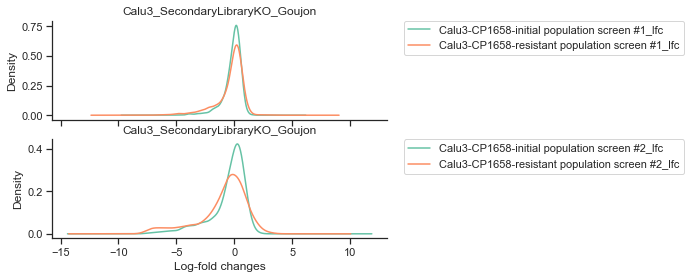

In [17]:
#Calculate log-fold change relative to pDNA
target_cols = list(lognorms.columns[3:])
pDNA_lfc = fns.calculate_lfc(lognorms,target_cols)
pDNA_lfc
pair1 = list(pDNA_lfc.columns[2:4])
pair2 = list(pDNA_lfc.columns[-2:])
paired_cols = (True, [pair1, pair2])
#Plot population distributions of log-fold changes 
fns.lfc_dist_plot(pDNA_lfc, paired_cols=paired_cols, filename = 'Calu3_SecondaryLibraryKO_Goujon')


### Distributions of control sets 

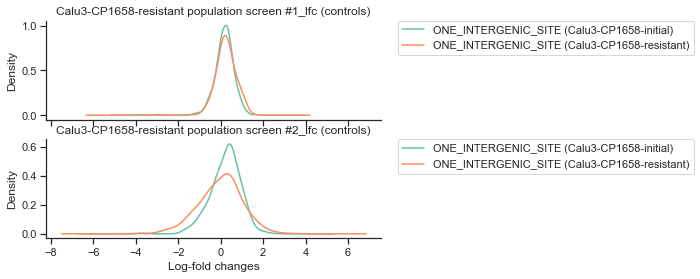

In [18]:
fns.control_dist_plot(pDNA_lfc, paired_cols=paired_cols, control_name=['ONE_INTERGENIC_SITE'], filename = 'Calu3_SecondaryLibraryKO_Goujon')


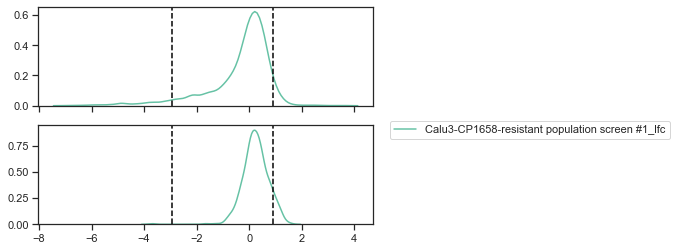

In [63]:
# Get controls
control_df = fns.get_controls(pDNA_lfc, control_name=['ONE_INTERGENIC_SITE'])
control_df
# Screen #1 control vs test 
fig, axs = plt.subplots(nrows=2, ncols = 1, sharex= True, figsize=(6, 4))
s = sns.kdeplot(data = pDNA_lfc['Calu3-CP1658-resistant population screen #1_lfc'], ax = axs[0], legend=False)
s = sns.kdeplot(data = control_df['Calu3-CP1658-resistant population screen #1_lfc'], ax = axs[1])
axs[1].legend(bbox_to_anchor=(1.05, 1.05), loc=2, borderaxespad=0.)    

screen1_fifth_percentile = pDNA_lfc['Calu3-CP1658-resistant population screen #1_lfc'].quantile(0.05)
screen1_95th_percentile = pDNA_lfc['Calu3-CP1658-resistant population screen #1_lfc'].quantile(0.95)
axs[0].axvline(screen1_fifth_percentile, linestyle = '--', color = 'k')
axs[1].axvline(screen1_fifth_percentile, linestyle = '--', color = 'k')
axs[0].axvline(screen1_95th_percentile, linestyle = '--', color = 'k')
axs[1].axvline(screen1_95th_percentile, linestyle = '--', color = 'k')




### ROC_AUC

Essential gene set: Hart et al., 2015 <br>
Non-essential gene set: Hart et al., 2014 <br>

Text(0, 0.5, 'True Positive Rate (essential)')

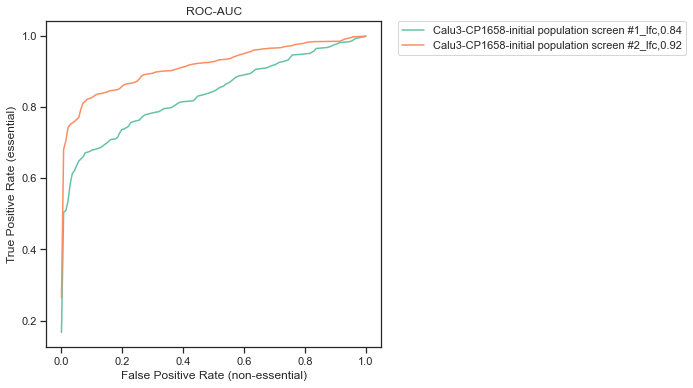

In [19]:
ess_genes, non_ess_genes = fns.get_gene_sets()
initial_cols = [col for col in pDNA_lfc.columns if 'initial' in col]

tp_genes = ess_genes.loc[:, 'Gene Symbol'].to_list()

fp_genes = non_ess_genes.loc[:, 'Gene Symbol'].to_list()

initial_roc_dict = {}
intial_roc_auc_dict = {}
for col in initial_cols:
    roc_auc, roc_df = pool.get_roc_aucs(pDNA_lfc, tp_genes, fp_genes, gene_col = 'Gene Symbol', score_col=col)
    initial_roc_dict[col] = roc_df
    intial_roc_auc_dict[col] = roc_auc

fig,ax=plt.subplots(figsize=(6,6))

for key, df in initial_roc_dict.items():
    roc_auc = intial_roc_auc_dict[key]
    ax=sns.lineplot(data=df, x='fpr',y='tpr', ci=None, label = key+',' + str(round(roc_auc,2)))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ROC-AUC')
plt.xlabel('False Positive Rate (non-essential)')
plt.ylabel('True Positive Rate (essential)')


## Gene level analysis

### Residual z-scores

In [20]:
lfc_df = pDNA_lfc.drop('Gene Symbol', axis = 1)
lfc_df

,Construct Barcode,Calu3-CP1658-initial population screen #1_lfc,Calu3-CP1658-resistant population screen #1_lfc,Calu3-CP1658-initial population screen #2_lfc,Calu3-CP1658-resistant population screen #2_lfc
0,AAAAAAAATCTTGCTCAGGG,-0.303857,0.505990,0.104272,0.321146
1,AAAAAATCGAACCATCTGAA,0.087777,0.157106,0.756043,0.164593
2,AAAAAGCACTACCGTACCAT,-0.874143,-1.058106,-0.251629,-2.410225
3,AAAAATCCTCTGAAGCCGCA,-0.892954,-1.846560,-5.072155,-6.520540
4,AAAAATTGTAGGGCGCACCA,-2.148229,-4.297971,-6.672148,-7.307299
...,...,...,...,...,...
6277,TTTGTCCCTTCTTAAAAAAC,0.358654,0.247476,-0.468377,0.140391
6278,TTTGTCCCTTCTTAAAAAAC,0.358654,0.247476,-0.468377,0.140391
6279,TTTGTCGTGAAGATGCACAA,-0.037008,1.134491,-0.445390,1.309112
6280,TTTGTGCTCACCTACAAGCT,-0.766661,-0.662139,-1.132706,-1.445489


In [21]:
# run_guide_residuals(lfc_df.drop_duplicates(), cols)
residuals_lfcs, all_model_info, model_fit_plots = run_guide_residuals(lfc_df, paired_lfc_cols=paired_cols[1])
residuals_lfcs


                                          modified  \
0  Calu3-CP1658-resistant population screen #1_lfc   
1  Calu3-CP1658-resistant population screen #2_lfc   

                                     unperturbed  
0  Calu3-CP1658-initial population screen #1_lfc  
1  Calu3-CP1658-initial population screen #2_lfc  


,Construct Barcode,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,AAAAAAAATCTTGCTCAGGG,Calu3-CP1658-resistant population screen #1_lfc,0.901973,1.505399,Calu3-CP1658-initial population screen #1_lfc,0.505990,-0.303857
1,AAAAAATCGAACCATCTGAA,Calu3-CP1658-resistant population screen #1_lfc,0.073362,0.122442,Calu3-CP1658-initial population screen #1_lfc,0.157106,0.087777
2,AAAAAGCACTACCGTACCAT,Calu3-CP1658-resistant population screen #1_lfc,0.315889,0.527221,Calu3-CP1658-initial population screen #1_lfc,-1.058106,-0.874143
3,AAAAATCCTCTGAAGCCGCA,Calu3-CP1658-resistant population screen #1_lfc,-0.441390,-0.736682,Calu3-CP1658-initial population screen #1_lfc,-1.846560,-0.892954
4,AAAAATTGTAGGGCGCACCA,Calu3-CP1658-resistant population screen #1_lfc,-1.089047,-1.817627,Calu3-CP1658-initial population screen #1_lfc,-4.297971,-2.148229
...,...,...,...,...,...,...,...
12163,TTTGTCACTAAAGTGGACAA,Calu3-CP1658-resistant population screen #2_lfc,-0.185146,-0.203690,Calu3-CP1658-initial population screen #2_lfc,-1.846527,-1.055015
12164,TTTGTCCCTTCTTAAAAAAC,Calu3-CP1658-resistant population screen #2_lfc,1.081687,1.190031,Calu3-CP1658-initial population screen #2_lfc,0.140391,-0.468377
12165,TTTGTCGTGAAGATGCACAA,Calu3-CP1658-resistant population screen #2_lfc,2.221821,2.444363,Calu3-CP1658-initial population screen #2_lfc,1.309112,-0.445390
12166,TTTGTGCTCACCTACAAGCT,Calu3-CP1658-resistant population screen #2_lfc,0.309935,0.340979,Calu3-CP1658-initial population screen #2_lfc,-1.445489,-1.132706


In [22]:
guide_mapping = pool.group_pseudogenes(chip[['Construct Barcode', 'Gene Symbol']], pseudogene_size=10, gene_col='Gene Symbol', control_regex=['ONE_INTERGENIC_SITE'])
guide_mapping

,Construct Barcode,Gene Symbol
0,AAAAAAAATCTTGCTCAGGG,HYMAI
1,AAAAAATCGAACCATCTGAA,USP14
2,AAAAAGCACTACCGTACCAT,SLC26A7
3,AAAAATCCTCTGAAGCCGCA,TOP3A
4,AAAAATTGTAGGGCGCACCA,NCAPG
...,...,...
6277,TTTGTCCCTTCTTAAAAAAC,TXN
6278,TTTGTCCCTTCTTAAAAAAC,TXNP6
6279,TTTGTCGTGAAGATGCACAA,CREBBP
6280,TTTGTGCTCACCTACAAGCT,MFSD3


In [23]:
gene_residuals = anchors.get_gene_residuals(residuals_lfcs.drop_duplicates(), guide_mapping)
gene_residuals

,condition,Gene Symbol,guides,avg_lfc,avg_lfc_reference,residual_zscore,p_value,fdr_bh
0,Calu3-CP1658-resistant population screen #1_lfc,ACE2,10,2.334673,0.150963,11.746993,7.317689e-32,1.238519e-29
1,Calu3-CP1658-resistant population screen #1_lfc,ACR,10,-0.153952,0.056116,-0.863388,3.879239e-01,7.439787e-01
2,Calu3-CP1658-resistant population screen #1_lfc,ACTR2,10,-2.456246,-1.399798,-1.652732,9.838552e-02,3.741966e-01
3,Calu3-CP1658-resistant population screen #1_lfc,ACTR3,10,-1.664302,-1.114269,0.386123,6.994058e-01,9.172866e-01
4,Calu3-CP1658-resistant population screen #1_lfc,ADAM7,10,0.358525,0.031518,2.112553,3.463903e-02,1.832377e-01
...,...,...,...,...,...,...,...,...
1349,Calu3-CP1658-resistant population screen #2_lfc,ZNF572,10,-0.051070,0.269841,-0.179636,8.574380e-01,9.872020e-01
1350,Calu3-CP1658-resistant population screen #2_lfc,ZNF594,10,0.055749,0.090731,0.953006,3.405869e-01,7.990580e-01
1351,Calu3-CP1658-resistant population screen #2_lfc,ZNF7,10,-0.419511,-0.197031,0.551042,5.816046e-01,9.135645e-01
1352,Calu3-CP1658-resistant population screen #2_lfc,ZNF703,10,-0.525216,-0.494502,1.395175,1.629631e-01,5.898341e-01


Average across guides and conditions and filter by number of guides per gene

In [24]:
gene_residual_sheet = fns.format_gene_residuals(gene_residuals, guide_min = 8, guide_max = 11)

guide_residual_sheet = pd.merge(guide_mapping, residuals_lfcs.drop_duplicates(), on = 'Construct Barcode', how = 'inner')
guide_residual_sheet

['Calu3-CP1658-resistant population screen #2_lfc', 'Calu3-CP1658-resistant population screen #1_lfc']
Calu3-CP1658-resistant population screen #2_lfc
Calu3-CP1658-resistant population screen #1_lfc


,Construct Barcode,Gene Symbol,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,AAAAAAAATCTTGCTCAGGG,HYMAI,Calu3-CP1658-resistant population screen #1_lfc,0.901973,1.505399,Calu3-CP1658-initial population screen #1_lfc,0.505990,-0.303857
1,AAAAAAAATCTTGCTCAGGG,HYMAI,Calu3-CP1658-resistant population screen #2_lfc,0.541525,0.595765,Calu3-CP1658-initial population screen #2_lfc,0.321146,0.104272
2,AAAAAATCGAACCATCTGAA,USP14,Calu3-CP1658-resistant population screen #1_lfc,0.073362,0.122442,Calu3-CP1658-initial population screen #1_lfc,0.157106,0.087777
3,AAAAAATCGAACCATCTGAA,USP14,Calu3-CP1658-resistant population screen #2_lfc,-0.457527,-0.503354,Calu3-CP1658-initial population screen #2_lfc,0.164593,0.756043
4,AAAAAGCACTACCGTACCAT,SLC26A7,Calu3-CP1658-resistant population screen #1_lfc,0.315889,0.527221,Calu3-CP1658-initial population screen #1_lfc,-1.058106,-0.874143
...,...,...,...,...,...,...,...,...
12559,TTTGTCGTGAAGATGCACAA,CREBBP,Calu3-CP1658-resistant population screen #2_lfc,2.221821,2.444363,Calu3-CP1658-initial population screen #2_lfc,1.309112,-0.445390
12560,TTTGTGCTCACCTACAAGCT,MFSD3,Calu3-CP1658-resistant population screen #1_lfc,0.531150,0.886492,Calu3-CP1658-initial population screen #1_lfc,-0.662139,-0.766661
12561,TTTGTGCTCACCTACAAGCT,MFSD3,Calu3-CP1658-resistant population screen #2_lfc,0.309935,0.340979,Calu3-CP1658-initial population screen #2_lfc,-1.445489,-1.132706
12562,TTTGTGTTGATGAATCCTGG,IL1R1,Calu3-CP1658-resistant population screen #1_lfc,0.680987,1.136572,Calu3-CP1658-initial population screen #1_lfc,0.597459,-0.081126


In [25]:
with pd.ExcelWriter('../../../Data/Processed/GEO_submission_v2/Calu3_SecondaryLibraryKO_Goujon.xlsx') as writer:  
    gene_residual_sheet.to_excel(writer, sheet_name='Calu3_avg_zscore', index =False)
    reads.to_excel(writer, sheet_name='Calu3_genomewide_reads', index =False)
    guide_mapping.to_excel(writer, sheet_name='Calu3_guide_mapping', index =False)

In [26]:
screen1_df = gene_residuals[gene_residuals['condition'].str.contains('#1')]
screen2_df = gene_residuals[gene_residuals['condition'].str.contains('#2')]
zscore_df = pd.merge(screen1_df[['Gene Symbol', 'residual_zscore']], screen2_df[['Gene Symbol', 'residual_zscore']], on = 'Gene Symbol', how = 'outer', suffixes = ['_screen#1', '_screen#2'])
zscore_df

,Gene Symbol,residual_zscore_screen#1,residual_zscore_screen#2
0,ACE2,11.746993,8.012149
1,ACR,-0.863388,-0.034485
2,ACTR2,-1.652732,-2.560794
3,ACTR3,0.386123,-1.097875
4,ADAM7,2.112553,1.894642
...,...,...,...
672,ZNF572,-0.097696,-0.179636
673,ZNF594,1.377913,0.953006
674,ZNF7,-0.452186,0.551042
675,ZNF703,-1.257454,1.395175


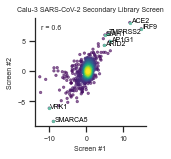

In [27]:
# Screen 2 vs Screen 1

fig, ax = plt.subplots(figsize = (2, 2))
ax = gpp.point_densityplot(zscore_df, 'residual_zscore_screen#1', 'residual_zscore_screen#2', s=6)
ax = gpp.add_correlation(zscore_df, 'residual_zscore_screen#1', 'residual_zscore_screen#2', fontsize=7)

top_ranked_screen1 = zscore_df.nsmallest(10, 'residual_zscore_screen#1')
top_ranked_screen2 = zscore_df.nsmallest(10, 'residual_zscore_screen#2')
bottom_ranked_screen1 = zscore_df.nlargest(10, 'residual_zscore_screen#1')
bottom_ranked_screen2 = zscore_df.nlargest(10, 'residual_zscore_screen#2')

screen1_ranked = pd.concat([top_ranked_screen1, bottom_ranked_screen1])
screen2_ranked = pd.concat([top_ranked_screen2, bottom_ranked_screen2])

# Annotate common hits
common_ranked = pd.merge(screen1_ranked, screen2_ranked, on = ['Gene Symbol', 'residual_zscore_screen#1', 'residual_zscore_screen#2'], how = 'inner')
common_ranked

sns.scatterplot(data=common_ranked, x='residual_zscore_screen#1', y='residual_zscore_screen#2', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, rasterized=True)

texts= []
for j, row in common_ranked.iterrows():
    texts.append(ax.text(row['residual_zscore_screen#1']+0.25, row['residual_zscore_screen#2'], row['Gene Symbol'], fontsize=7,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

plt.title('Calu-3 SARS-CoV-2 Secondary Library Screen', fontsize=7)
plt.xlabel('Screen #1', fontsize=7)
plt.ylabel('Screen #2', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
sns.despine()
gpp.savefig('../../../Figures/Scatterplots/Calu3_KO_Secondary_Screen1vs2_scatterplot.pdf', dpi=300)



In [28]:
with pd.ExcelWriter('../../../Data/Processed/Individual_screens_v2/Calu3_SecondaryLibraryKO_Goujon_indiv_screens.xlsx') as writer:  
    zscore_df.to_excel(writer, sheet_name='indiv_screen_zscore', index =False)
    gene_residuals.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
    guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)